In [13]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import pandas as pd

#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

In [14]:
# load the database
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

print('snowexsql database successfully loaded!')

snowexsql database successfully loaded!


In [15]:
def parse_veg_class(site_id):
    
    '''
    This function parses snow pit data into three vegetation classes:
        - 1). Treeless, 2). Sparce, and 3). Dense
        
    It uses a python dictionary where:
        (k) keys: are the vegetation classes
        (v) values: are the first digit in the pitID assignment

    
    '''
    
    # Classifying by vegetation coverage 
    veg_class = {'treeless':[1, 2, 3], 'sparse':[4, 5, 6], 'dense':[7, 8, 9]}
     
    vclass = None 
    
    class_id = site_id[0]
    
    if class_id.isnumeric():
        class_id = int(class_id)

        for k,v in veg_class.items():

            if class_id in v: #if the first digit in the site_id is 'v' assign it to the corresponding 'k'
                vclass = k 
                
    return vclass 

In [16]:
def parse_depth_class(site_id):
    
    '''
    This function parses snow pit data into three depth classes:
        - 1). Shallow, 2). Medium, and 3). Deep
        
    It uses a python dictionary where:
        (k) keys: are the depth classes
        (v) values: are the first digit in the pitID assignment
      
  
    '''
        
    # Classifying by 2017 depth 
    depth_class = {'shallow':[1, 4, 7], 'medium':[2, 5, 8], 'deep':[3, 6, 9]} 
   
    dclass = None 
    
    class_id = site_id[0]
    
    if class_id.isnumeric(): #for the outlier TS site
        class_id = int(class_id) #cast as integer

        for k,v in depth_class.items(): #for the key, value pairs in the dict listed above:

            if class_id in v: #if the first digit in the site_id is 'v' assign it to the corresponding 'k'
                dclass = k 

    return dclass 

In [22]:
# Load the database
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Query for Layer Data
#result = session.query(LayerData.type).distinct().all()

# Filter for density data
qry = session.query(LayerData).filter(LayerData.type=='temperature')

# Form our dataframe from the query 
df = query_to_geopandas(qry, engine)
df['value'] = df['value'].astype(float)  #cast the value as a float (they are strings)

# Parse snow pit data by the veg/depth matrix
df['veg_class'] = [parse_veg_class(i) for i in df['site_id']] #run the parse_veg function for every site_id
df['depth_class'] = [parse_depth_class(i) for i in df['site_id']] #run the parse_depth funciton for every site_id

## Select columns of interest
#col_list = ['site_id', 'date', 'type', 'latitude',
#       'longitude', 'depth', 'value', 'veg_class', 'depth_class']
#df = df[col_list]

# View a sample --> notice parsed veg_class and depth_class columns were added!
df.head(10)

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,depth,site_id,bottom_depth,comments,sample_a,sample_b,sample_c,value,veg_class,depth_class
0,Grand Mesa,2020-01-30,2021-06-01 18:41:09.314102+00:00,None,231,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,90.0,5C21,None,None,None,None,None,-13.2,sparse,medium
1,Grand Mesa,2020-01-31,2021-06-01 18:41:08.470616+00:00,None,139,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,78.0,8C26,None,None,None,None,None,-6.1,dense,medium
2,Grand Mesa,2020-01-31,2021-06-01 18:41:08.477151+00:00,None,140,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,70.0,8C26,None,None,None,None,None,-9.8,dense,medium
3,Grand Mesa,2020-01-31,2021-06-01 18:41:08.486020+00:00,None,141,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,60.0,8C26,None,None,None,None,None,-8.3,dense,medium
4,Grand Mesa,2020-01-31,2021-06-01 18:41:08.493826+00:00,None,142,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,50.0,8C26,None,None,None,None,None,-6.3,dense,medium
5,Grand Mesa,2020-01-31,2021-06-01 18:41:08.497647+00:00,None,143,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,40.0,8C26,None,None,None,None,None,-5.0,dense,medium
6,Grand Mesa,2020-01-31,2021-06-01 18:41:08.501737+00:00,None,144,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,30.0,8C26,None,None,None,None,None,-4.3,dense,medium
7,Grand Mesa,2020-01-31,2021-06-01 18:41:08.507625+00:00,None,145,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,20.0,8C26,None,None,None,None,None,-3.7,dense,medium
8,Grand Mesa,2020-01-31,2021-06-01 18:41:08.513749+00:00,None,146,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,10.0,8C26,None,None,None,None,None,-3.0,dense,medium
9,Grand Mesa,2020-01-31,2021-06-01 18:41:08.519691+00:00,None,147,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,0.0,8C26,None,None,None,None,None,-2.3,dense,medium


In [122]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   site_name      1675 non-null   object             
 1   date           1675 non-null   object             
 2   time_created   1675 non-null   datetime64[ns, UTC]
 3   time_updated   0 non-null      object             
 4   id             1675 non-null   int64              
 5   doi            1675 non-null   object             
 6   date_accessed  1675 non-null   object             
 7   instrument     0 non-null      object             
 8   type           1675 non-null   object             
 9   units          0 non-null      object             
 10  surveyors      0 non-null      object             
 11  latitude       1675 non-null   float64            
 12  longitude      1675 non-null   float64            
 13  northing       1675 non-null   float64  

In [62]:
df.loc[(df['site_id']=='8C26') & (df['depth']==0)]

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,geom,time,depth,site_id,bottom_depth,comments,sample_a,sample_b,sample_c,value
467,Grand Mesa,2020-01-31,2021-06-01 18:41:08.519691+00:00,None,147,https://doi.org/10.5067/DUD2VZEVBJ7S,2021-05-30,None,temperature,None,...,POINT (744396.000 4323540.000),12:53:00-06:00,0.0,8C26,None,None,None,None,None,-2.3


<AxesSubplot:>

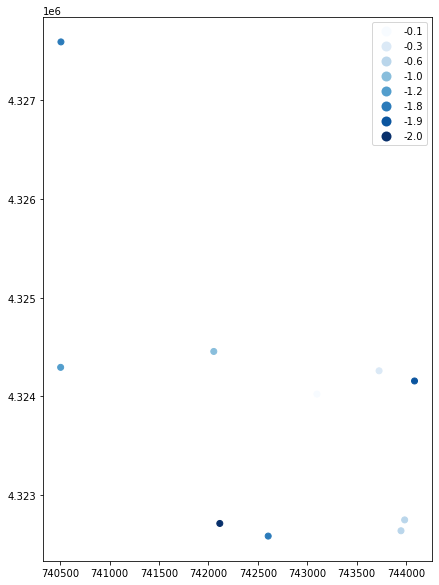

In [121]:
df.loc[(df['depth']==0) & (df['date']==datetime.date(2020, 2, 8))].plot(column='value', figsize=(10, 10), legend=True, cmap='Blues')

In [ ]:
# find data for 20200208
# this is when steven has data